# Постановка задачи

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

## Описание процесса обработки на каждой итерации.

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## Описание данных.

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## Целевой признак и метрики качества.

### Целевой признак: 

Последняя измеренная температура в каждой партии.

### Признаки:

Первая измеренная температура и остальные параметры коррелируемые с целевым признаком

### Метрика: 

MAE (минимальное значение)

In [94]:
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

Загрузка имещийся датасетов.

In [95]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

## Исследовательский анализ данных.

### Данные о электродах

In [96]:
data_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


In [97]:
data_arc.tail()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768
14875,3241,2019-09-01 04:34:47,2019-09-01 04:36:08,0.306580,0.196708


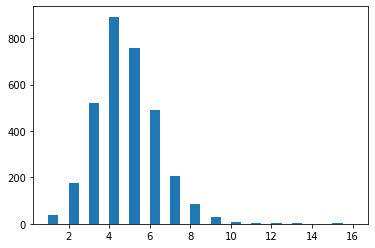

In [98]:
plt.hist((list(data_arc['key'].value_counts())), bins=30) # распределение количества итераций тех процесса в партиях
plt.show()

Количество итераций в каждой партии колеблиться от 1 до 15. Среднее количество итераций 4.

In [99]:
data_arc.info() # пропусков необнаружено

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [100]:
data_arc.describe(percentiles=[0.02,0.2,0.9,0.99]) # взглянем дополнительно по процентелям 2% 20% 90% и 99%

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
2%,64.000000,0.146947,0.105366
20%,647.000000,0.356037,0.259855
50%,1617.000000,0.555517,0.415962
90%,2913.000000,1.214875,0.909250
99%,3205.000000,2.079994,1.592817
max,3241.000000,3.731596,2.676388


Большое минимальное значение реактивной мощности это скорее всего ошибка датчика. В дальнейшем удалим его. Всего 3241 партия.

### Данные о подаче сыпучих материалов (объём)

In [101]:
data_bulk.head(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [102]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Такое большое количестов пропусков харрактерно для данного технологического процесса для каждой итерации. При поиске подходящего сосатва сплава добавляют различное количество материалов. Уместно заполнить пропуски нулями т. к. пропущенные значения говорят о том, что в данной итерации этот материал не вводится в сплав.

### Данные о подаче сыпучих материалов (время)

In [103]:
data_bulk_time.head(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [104]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Аналогичная ситуация с пропусками как и при оъеме сыпучих лигирующих добавок. 

### Данные о продувке сплава газом

In [105]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [106]:
data_gas.tail()

,key,Газ 1
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103
3238,3241,12.680959


In [107]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [108]:
data_gas.describe(percentiles=[0.02,0.2,0.9,0.99])

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
2%,65.760000,1.822306
20%,650.600000,6.487572
50%,1622.000000,9.836267
90%,2917.200000,18.550515
99%,3208.620000,31.558630
max,3241.000000,77.995040


In [109]:
keys = list(data_gas['key'])

In [110]:
count = []

In [111]:
for i in list(range(1, 3242)):
    if i not in keys:
        count.append(i)

In [112]:
count # партии в которых нет данных о газе

[193, 259]

### Результаты измерения температуры

In [113]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [114]:
data_temp.tail(30)

,key,Время замера,Температура
15877,3236,2019-08-31 22:31:42,NaN
15878,3237,2019-08-31 22:44:04,1569.0
15879,3237,2019-08-31 22:44:44,NaN
15880,3237,2019-08-31 22:51:02,NaN
15881,3237,2019-08-31 23:01:16,NaN
15882,3237,2019-08-31 23:05:43,NaN
15883,3238,2019-08-31 23:30:31,1584.0
15884,3238,2019-08-31 23:37:26,NaN
15885,3238,2019-08-31 23:43:00,NaN
15886,3239,2019-09-01 01:31:47,1598.0


In [115]:
data_temp[data_temp['Температура'].isnull()].head()

,key,Время замера,Температура
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN


In [116]:
data_temp[data_temp['Температура'].isnull()].tail()

,key,Время замера,Температура
15901,3240,2019-09-01 03:35:16,NaN
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN
15906,3241,2019-09-01 04:38:08,NaN


In [117]:
data_temp.describe(percentiles=[0.02,0.2,0.9,0.99])

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
2%,55.000000,1551.000000
20%,625.200000,1578.000000
50%,1618.000000,1591.000000
90%,2908.000000,1616.000000
99%,3205.000000,1654.000000
max,3241.000000,1705.000000


In [118]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [119]:
keys = list(data_temp['key'])

In [120]:
count = []

In [121]:
for i in list(range(1, 3242)):
    if i not in keys:
        count.append(i)

In [122]:
count

[41,
 42,
 355,
 382,
 506,
 529,
 540,
 607,
 683,
 710,
 766,
 1133,
 1300,
 1437,
 2031,
 2103,
 2278,
 2356,
 2373,
 2446,
 2469,
 2491,
 2683,
 3200,
 3207]

In [123]:
data_temp['key'].value_counts() 
# партии 195 и 279 не используем так как для целевого нужно как минимум первое и последнее значения температуры

44      16
1214    16
1513    16
46      16
1689    15
        ..
1106     2
1424     2
3156     2
279      1
195      1
Name: key, Length: 3216, dtype: int64

Много пропусков в стобце температур. С партии № 2500 нет значений температур кроме первого измерения. Это может связанно с сбоем работы датчиков.

### Данные о проволочных материалах (объём)

In [124]:
data_wire.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [125]:
data_wire.tail(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3071,3232,15.069600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3072,3233,107.147033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3073,3234,110.160957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3074,3235,125.099525,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3075,3236,101.162880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Пропуски можно заполнить нулями по аналогии с сыпучеми добавками.

### Данные о проволочных материалах (время)

In [126]:
data_wire_time.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [127]:
data_wire_time.tail(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3071,3232,2019-08-31 20:02:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3072,3233,2019-08-31 20:31:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3073,3234,2019-08-31 21:03:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3074,3235,2019-08-31 21:33:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3075,3236,2019-08-31 22:19:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,2019-09-01 04:16:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Так же как и с сыпучими добавками.

## План проекта:

* Обработка пропущенных значений
* Объеденение данных в один датасет (с 2499 партии т. к. дальше данных не достаточно для обучение и тестирования моделей)
* Выделение признаков
* Разбиение на тренировочную и тестовую выборки
* Генерация моделей и выбор модели с минимальным МАЕ

## Предобработка данных.

Для обучения и тестирования будем использовать кроссвалидацию, а так же исключим из data_temp партии с 2500 по 3241 так как в них есть только значения температуры первой итерации. И исключим партии 195 и 279 так как в них тоже по одному значению температур.

In [128]:
data_temp = data_temp.query('key < 2500') # для моделирования используем данные только до 2499 партии включительно.

In [129]:
data_temp = data_temp.query('key not in (195, 279)') # исключаем так же партии 195 и 279

In [130]:
data_arc[data_arc['key']==195] # проверка

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность


In [131]:
data_arc[data_arc['key']==279] # проверка

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность


In [132]:
data_gas[data_gas['key']==195] # проверка

,key,Газ 1
193,195,0.374436


In [133]:
data_gas[data_gas['key']==279] # проверка

,key,Газ 1
276,279,7.232359


In [134]:
data_gas = data_gas.query('key not in (195, 279)') # исключение партий 195 и 279

In [135]:
data_gas[data_gas['key']==195] # проверка

,key,Газ 1


In [136]:
data_gas[data_gas['key']==279] # проверка

,key,Газ 1


По лигирующим материалам используем данные о материалах где больше 30 объектов, что бы не засорять данные пустыми значениями.

In [137]:
data_bulk_col = ['Bulk 2', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 13'] # меньше 30 объектов сыпучие

In [138]:
data_wire_col = ['Wire 4', 'Wire 5', 'Wire 7', 'Wire 8', 'Wire 9'] # меньше 30 объектов проволока

In [139]:
data_bulk = data_bulk.drop(data_bulk_col, axis=1) # удаление сыпучих столбцов <30

In [140]:
data_wire = data_wire.drop(data_wire_col, axis=1) # удаление проволочных столбцов <30

С учетом всех допущений заполняем пропущенные значения всех лигирующих материалов нулями.

In [141]:
data_bulk = data_bulk.query('key not in (195, 279) and key < 2500').fillna(0)

In [142]:
data_wire = data_wire.query('key not in (195, 279) and key < 2500').fillna(0)

Реактивная мощность больше нуля (удаляем анамальные отрицательные значения)

In [143]:
data_arc = data_arc[data_arc['Реактивная мощность'] > 0]

In [144]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера']) # приведения типа данных datetime

## Подготовка данных для объеденения

In [145]:
last_time_temp_key = pd.to_datetime(data_temp.groupby('key')['Время замера'].max())
# время последнего измерения температуры каждой партии

In [146]:
target_temp = data_temp.merge(last_time_temp_key, on="Время замера").rename(columns={"Время замера": "last_time", "Температура": "last_temp"})
# целевой признак последняя измерянная температура каждой партии

In [147]:
target_temp.head(1)

,key,last_time,last_temp
0,1,2019-05-03 11:30:39,1613.0


In [148]:
first_time_temp_key = pd.to_datetime(data_temp.groupby('key')['Время замера'].min())
# время стартового измерения температуры для каждой партии

In [149]:
first_temp = data_temp.merge(first_time_temp_key, on="Время замера").rename(columns={"Время замера": "first_time", "Температура": "first_temp"})

In [150]:
first_temp.head(1)

,key,first_time,first_temp
0,1,2019-05-03 11:16:18,1571.0


In [151]:
count = data_arc.query('key < 2500')['key'].value_counts().sort_index().reset_index().rename(columns={"index": "key", "key": "count"})
# количество попыток легирования для каждой партии

In [152]:
count.head(1)

,key,count
0,1,5


In [153]:
power_sum = data_arc.query('key < 2500').groupby('key')['Активная мощность', 'Реактивная мощность'].sum().reset_index().rename(columns={"Активная мощность": "active_power", "Реактивная мощность": "reactive_power"})
# общие затраты энергии по активной и реактивной мощности для каждой партии

In [154]:
power_sum['sum_power'] = (power_sum['active_power']**2 + power_sum['reactive_power']**2)**0.5 # общая мощность

In [155]:
power_sum.head(1)

,key,active_power,reactive_power,sum_power
0,1,4.878147,3.183241,5.824889


Приведем все значения дат в типу datetime

In [156]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])

In [157]:
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])

Начало и конец нагрева дугой.

In [158]:
start = pd.to_datetime(data_arc.groupby('key')['Начало нагрева дугой'].min()).reset_index()

In [159]:
stop = pd.to_datetime(data_arc.groupby('key')['Конец нагрева дугой'].max()).reset_index()

In [160]:
data_arc['sum_sec_term'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']) // pd.Timedelta('1s')
# длительность нагрева в секундах для каждой итерации в каждой партии

In [161]:
arc_sec_term = data_arc.query('key < 2500').groupby('key')['sum_sec_term'].sum().reset_index()
# сумарная длительность нагрева для каждой партии

In [162]:
arc_sec_term.head(1)

,key,sum_sec_term
0,1,1098


In [163]:
arc_sec_term = arc_sec_term.merge(start, on='key')

In [164]:
arc_sec_term = arc_sec_term.merge(stop, on='key')

In [165]:
arc_sec_term = arc_sec_term.rename(columns={"Начало нагрева дугой": "start", "Конец нагрева дугой": "stop"})

In [166]:
arc_sec_term.head(1)

,key,sum_sec_term,start,stop
0,1,1098,2019-05-03 11:02:14,2019-05-03 11:28:37


In [167]:
data_gas = data_gas.query('key < 2500').rename(columns={"Газ 1": "gas"})

In [168]:
data_gas.head(1)

,key,gas
0,1,29.749986


## Объеденение данных в общий датасет.

In [169]:
data = data_gas.merge(target_temp, on='key')

In [170]:
data.head(1)

,key,gas,last_time,last_temp
0,1,29.749986,2019-05-03 11:30:39,1613.0


In [171]:
data = data.merge(count, on='key')

In [172]:
data.head(1)

,key,gas,last_time,last_temp,count
0,1,29.749986,2019-05-03 11:30:39,1613.0,5


In [173]:
data = data.merge(power_sum, on='key')

In [174]:
data.head(1)

,key,gas,last_time,last_temp,count,active_power,reactive_power,sum_power
0,1,29.749986,2019-05-03 11:30:39,1613.0,5,4.878147,3.183241,5.824889


In [175]:
data = data.merge(arc_sec_term, on='key')

In [176]:
data.head(1)

,key,gas,last_time,last_temp,count,active_power,reactive_power,sum_power,sum_sec_term,start,stop
0,1,29.749986,2019-05-03 11:30:39,1613.0,5,4.878147,3.183241,5.824889,1098,2019-05-03 11:02:14,2019-05-03 11:28:37


In [177]:
data = data.merge(first_temp, on='key')

In [178]:
data.head(1)

,key,gas,last_time,last_temp,count,active_power,reactive_power,sum_power,sum_sec_term,start,stop,first_time,first_temp
0,1,29.749986,2019-05-03 11:30:39,1613.0,5,4.878147,3.183241,5.824889,1098,2019-05-03 11:02:14,2019-05-03 11:28:37,2019-05-03 11:16:18,1571.0


In [179]:
data = data.merge(data_bulk, on='key')

In [180]:
data = data.merge(data_wire, on='key')

## Создание признаков

In [181]:
data['power_ratio'] = data['reactive_power'] / data['active_power'] # отношение активной и реактивной мощностей

In [182]:
data['param1'] = (data['first_time'] - data['start']) // pd.Timedelta('1s') # признаки интервалов времени работы дуги

In [183]:
data['param2'] = (data['stop'] - data['start']) // pd.Timedelta('1s') # признаки интервалов времени работы дуги

In [184]:
data['param3'] = (data['last_time'] - data['start']) // pd.Timedelta('1s') # признаки интервалов времени работы дуги

In [185]:
time_columns = ['start', 'stop', 'first_time', 'last_time',]

In [186]:
data = data.drop(time_columns, axis=1)

In [187]:
data.info() # итоговый датасэт

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 27 columns):
key               2329 non-null int64
gas               2329 non-null float64
last_temp         2329 non-null float64
count             2329 non-null int64
active_power      2329 non-null float64
reactive_power    2329 non-null float64
sum_power         2329 non-null float64
sum_sec_term      2329 non-null int64
first_temp        2329 non-null float64
Bulk 1            2329 non-null float64
Bulk 3            2329 non-null float64
Bulk 4            2329 non-null float64
Bulk 5            2329 non-null float64
Bulk 6            2329 non-null float64
Bulk 10           2329 non-null float64
Bulk 11           2329 non-null float64
Bulk 12           2329 non-null float64
Bulk 14           2329 non-null float64
Bulk 15           2329 non-null float64
Wire 1            2329 non-null float64
Wire 2            2329 non-null float64
Wire 3            2329 non-null float64
Wire 6            2

In [188]:
data.head(3)

,key,gas,last_temp,count,active_power,reactive_power,sum_power,sum_sec_term,first_temp,Bulk 1,...,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 6,power_ratio,param1,param2,param3
0,1,29.749986,1613.0,5,4.878147,3.183241,5.824889,1098,1571.0,0.0,...,150.0,154.0,60.059998,0.0,0.0,0.0,0.652551,844,1583,1705
1,2,12.555561,1602.0,4,3.052598,1.998112,3.648398,811,1581.0,0.0,...,149.0,154.0,96.052315,0.0,0.0,0.0,0.654561,193,1144,1498
2,3,28.554793,1599.0,5,2.525882,1.599076,2.989502,655,1596.0,0.0,...,152.0,153.0,91.160157,0.0,0.0,0.0,0.633076,383,1525,1683


## Получение мотелей и тесты.

In [189]:
X = data.drop('last_temp', axis=1)

In [190]:
y = data['last_temp']

In [191]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)

In [192]:
sc = StandardScaler().fit(X_train) # скалирование выборок
X_train_scaled = sc.transform(X_train)
X_test_scaled = sc.transform(X_test)

In [193]:
kf = KFold(n_splits=5, shuffle=False) # кросвалидация на 5 подвыборках

### Линейная регрессия

In [194]:
parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}
grid_lr = GridSearchCV(LinearRegression(), parameters, cv=kf, scoring='neg_mean_absolute_error')
grid_lr.fit(X_train_scaled, y_train)
params = grid_lr.best_params_
print('MAE на кросс-валидации: ', abs(grid_lr.best_score_))
lr = LinearRegression(**params)
lr.fit(X_train_scaled, y_train)
pred_test = lr.predict(X_test_scaled)
print(params)
print("MAE на тестовой выборке: ", mean_absolute_error(y_test, pred_test))

MAE на кросс-валидации:  6.385331169199576
{'fit_intercept': True, 'normalize': True}
MAE на тестовой выборке:  6.05746436266255


### Случайный лес.

In [195]:
tree_params = {'n_estimators': [300], 'max_depth': [10, 12], 'min_samples_split': [2, 5]}

In [196]:
grid_rfr = GridSearchCV(RandomForestRegressor(random_state=12345), tree_params, refit=False, cv=5, scoring='neg_mean_absolute_error') 
grid_rfr.fit(X_train_scaled, y_train)
print('MAE на кросс-валидации: ', abs(grid_rfr.best_score_))
params = grid_rfr.best_params_
rfr = RandomForestRegressor(**params, random_state=12345)
rfr.fit(X_train_scaled, y_train)
pred_test = rfr.predict(X_test_scaled)
print(params)
print("MAE на тестовой выборке: ", mean_absolute_error(y_test, pred_test))

MAE на кросс-валидации:  5.935475075219733
{'max_depth': 12, 'min_samples_split': 2, 'n_estimators': 300}
MAE на тестовой выборке:  5.792851243145462


### Градаентные бурстинги.

#### LGBM

In [146]:
param_grid = {'n_estimators': [300], 'learning_rate': [0.03, 0.06], 'max_depth': [4, 6]}

In [147]:
grid_lgbm = GridSearchCV(lgb.LGBMRegressor(random_state=12345), param_grid, cv=5, scoring='neg_mean_absolute_error', refit=False) 
grid_lgbm.fit(X_train_scaled, y_train)
print('MAE на кросс-валидации: ', abs(grid_lgbm.best_score_))
params = grid_lgbm.best_params_
lgbm = lgb.LGBMRegressor(**params, random_state=12345)
lgbm.fit(X_train_scaled, y_train)
pred_test = lgbm.predict(X_test_scaled)
print(params)
print("MAE на тестовой выборке: ", mean_absolute_error(y_test, pred_test))

MAE на кросс-валидации:  5.680592659941855
{'learning_rate': 0.03, 'max_depth': 6, 'n_estimators': 300}
MAE на тестовой выборке:  5.472491919062272


#### CatBoost

In [197]:
param_grid_ctb = {'n_estimators': [300], 'learning_rate': [0.1, 0.2], 'depth': [4, 6]}

In [198]:
grid_ctb = GridSearchCV(CatBoostRegressor(random_state=12345, silent=True), 
                    param_grid_ctb, cv=5, scoring='neg_mean_absolute_error', refit=False) 
grid_ctb.fit(X_train_scaled, y_train)
print('MAE на кросс-валидации: ', abs(grid_ctb.best_score_))
params = grid_ctb.best_params_
ctb = CatBoostRegressor(**params, random_state=12345, silent=True)
ctb.fit(X_train_scaled, y_train)
pred_test = ctb.predict(X_test_scaled)
print(params)
print("MAE на тестовой выборке: ", mean_absolute_error(y_test, pred_test))

MAE на кросс-валидации:  5.548792174689509
{'depth': 6, 'learning_rate': 0.1, 'n_estimators': 300}
MAE на тестовой выборке:  5.407439936362403


## Выводы

* Был получен общий датасет с дополнительными параметрами временами работы нагревательнго элемента и общей, реактивной и активной мощностями.
* Пустые значения для лигирующих элементов были заполненны нулями и столбы с количесмтвом значений меньше 30 значений были удалены.
* Партии с 2500 и до последней были исключены из дата сета.
* Были исключены отрицательные значения мощностей.
* При моделировании использовались тренировочная и тестовая выборки в соотношении 80:20. А так же кросс-валидация.
* Для получения моделей использовались линейная регрессия, случайный лес, градиентные бустинги LGBM и CatBoost.
* Лучшая модель CatBoost:

MAE на кросс-валидации:  5.548792174689509

{'depth': 6, 'learning_rate': 0.1, 'n_estimators': 300}

MAE на тестовой выборке:  5.407439936362403

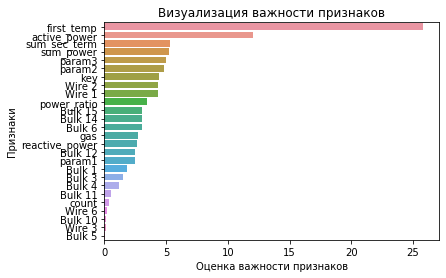

In [199]:
import seaborn as sns
def chart_feature_imp(model):
    feature_imp = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

    ax = sns.barplot(x=feature_imp, y=feature_imp.index)
    _ = ax.set(xlabel='Оценка важности признаков', ylabel='Признаки')
    _ = ax.set_title('Визуализация важности признаков')

chart_feature_imp(ctb)
